In [1]:
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import time

In [2]:
def solidez(img, sol_min = 0.0):

    contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    # Create an empty mask to draw the kept contours
    mask = np.zeros_like(img)
    
    if contours:
        hierarchy = hierarchy[0]
        for i, cnt in enumerate(contours):
            area_contorno = cv2.contourArea(cnt)
            casco_convexo = cv2.convexHull(cnt)
            area_casco_convexo = cv2.contourArea(casco_convexo)
            if area_casco_convexo > 0 :
                if (float(area_contorno) / area_casco_convexo) >= sol_min:
                    if hierarchy[i][3] == -1 :
                        cv2.drawContours(mask, contours, i, 255, thickness=cv2.FILLED)
                    else:
                        cv2.drawContours(mask, contours, i, 0, thickness=cv2.FILLED)
    
    # Return the mask with small white regions removed
    return mask

In [3]:
def remove_white(img, min_area_w=1000, min_area_b = 1000):


    contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img)


    if contours:
        hierarchy = hierarchy[0]

        for i, cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            if hierarchy[i][3] == -1:
                if area >= min_area_w:

                    cv2.drawContours(mask, contours, i, 255, thickness=cv2.FILLED)
            elif area >= min_area_b:

                cv2.drawContours(mask, contours, i, 0, thickness=cv2.FILLED)
    return mask


In [4]:
def baixar_imagem_arcg(x, y, z):
    """
    Função para baixar uma imagem de um tile específico do Google Maps.
    """
    url = f"https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
    response = requests.get(url)
    
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))

        image_cv = np.array(image)
        if image_cv.shape[2] == 4:
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGBA2BGR)
        else:
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
        return image_cv
    else:
        raise Exception(f"Erro ao baixar imagem: {response.status_code}")

In [5]:

def lat_lon_para_tile_xy(lat, lon, zoom):
    """
    Converte latitude e longitude em coordenadas de tile X e Y para um dado nível de zoom.
    """
    n = 2 ** zoom
    xtile = int((lon + 180.0) / 360.0 * n)
    lat_rad = np.radians(lat)
    ytile = int((1.0 - np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi) / 2.0 * n)
    return xtile, ytile

In [6]:
def tile_xy_para_bounds(xtile, ytile, zoom):
    """
    Retorna as coordenadas geográficas (em latitude e longitude) dos limites de um tile específico.
    """
    n = 2 ** zoom
    lon_left = xtile / n * 360.0 - 180.0
    lon_right = (xtile + 1) / n * 360.0 - 180.0
    lat_top_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
    lat_bottom_rad = np.arctan(np.sinh(np.pi * (1 - 2 * (ytile + 1) / n)))
    lat_top = np.degrees(lat_top_rad)
    lat_bottom = np.degrees(lat_bottom_rad)
    return (lon_left, lat_bottom, lon_right, lat_top)  # (min_lon, min_lat, max_lon, max_lat)

In [7]:
 def juntar_tiles_regiao(lat, lon, zoom, tile_gap):
     """
     Junta todos os tiles que cobrem a região de interesse definida pelos limites geográficos.
     """
     # Converter os limites geográficos para tiles
     xtile, ytile = lat_lon_para_tile_xy(lat, lon, zoom)
     
     # Garantir que os valores mínimos e máximos estão corretos
     xtile_min = xtile - tile_gap
     xtile_max = xtile + tile_gap
     ytile_min = ytile - tile_gap
     ytile_max = ytile + tile_gap
     tiles = (xtile_max-xtile_min)*(ytile_max-ytile_min)
     
     # Lista para armazenar as linhas de imagens
     linhas = []
     
     # Baixar e juntar as imagens dos tiles
     for y in range(ytile_min, ytile_max):
         linha_tiles = []
         for x in range(xtile_min, xtile_max):
             tile_image = baixar_imagem_google_maps(x, y, zoom)
             linha_tiles.append(tile_image)
         # Concatenar horizontalmente as imagens da mesma linha
         linha_concatenada = np.concatenate(linha_tiles, axis=1)
         linhas.append(linha_concatenada)
     
     # Concatenar verticalmente todas as linhas
     imagem_final = np.concatenate(linhas, axis=0)
     
     # Calcular os limites geográficos da imagem final
     # Top-left tile
     min_lon_final, _, _, max_lat_final = tile_xy_para_bounds(xtile_min, ytile_min, zoom)
     # Bottom-right tile
     _, min_lat_final, max_lon_final, _ = tile_xy_para_bounds(xtile_max, ytile_max, zoom)
     
     return imagem_final, (min_lon_final, min_lat_final, max_lon_final, max_lat_final), tiles

In [8]:
def juntar_tiles_regiao(lat, lon, zoom, tile_gap):
    """
    Junta todos os tiles que cobrem a região de interesse definida pelos limites geográficos.
    """
    # Converter os limites geográficos para tiles
    xtile, ytile = lat_lon_para_tile_xy(lat, lon, zoom)

    
    # Garantir que os valores mínimos e máximos estão corretos
    xtile_min = xtile - tile_gap
    xtile_max = xtile + tile_gap
    ytile_min = ytile - tile_gap
    ytile_max = ytile + tile_gap
    
    tiles = (xtile_max-xtile_min)*(ytile_max-ytile_min)
    print(f"Baixando tiles de x: {xtile_min} a {xtile_max}, y: {ytile_min} a {ytile_max}")
    print(f"Total de tiles: {tiles}")
    print(f"Área total trabalhada: {tiles*0.093} km²")
    
    # Lista para armazenar as linhas de imagens
    linhas = []
    
    # Baixar e juntar as imagens dos tiles
    for y in range(ytile_min, ytile_max + 1):
        linha_tiles = []
        for x in range(xtile_min, xtile_max + 1):
            tile_image = baixar_imagem_google_maps(x, y, zoom)
            linha_tiles.append(tile_image)
        # Concatenar horizontalmente as imagens da mesma linha
        linha_concatenada = np.concatenate(linha_tiles, axis=1)
        linhas.append(linha_concatenada)
    
    # Concatenar verticalmente todas as linhas
    imagem_final = np.concatenate(linhas, axis=0)
    
    # Calcular os limites geográficos da imagem final
    # Top-left tile
    min_lon_final, _, _, max_lat_final = tile_xy_para_bounds(xtile_min, ytile_min, zoom)
    # Bottom-right tile
    _, min_lat_final, max_lon_final, _ = tile_xy_para_bounds(xtile_max, ytile_max, zoom)
    
    return imagem_final, (min_lon_final, min_lat_final, max_lon_final, max_lat_final), tiles

In [9]:
#mais especifico
def processar_imagem(imagem):
    """
    Processa uma imagem para identificar talhões e retorna os contornos identificados.
    """
    borrada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
    
   # Converter para o espaço de cor HSV

    
    # Certificar-se de que os valores estão dentro dos limites válidos
    kernel = np.ones((3,3), np.uint8)
    borrada = cv2.GaussianBlur(hsv, (11,11), 0)
    bordas = cv2.Canny(borrada, 50, 150)

    # Dilatação para engrossar as bordas
    bordas = cv2.dilate(bordas, kernel, iterations=1)
    
    # Fechamento para fechar pequenas aberturas nas bordas

    bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
    

    _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)


    bordas = remove_white(bordas, 5000, 5000)

    aux = bordas

    filtrada = cv2.bitwise_and(hsv, hsv, mask=bordas)
    filtrada = cv2.GaussianBlur(filtrada, (5,5), 0)
    bordas_filtrada = cv2.Canny(filtrada, 50, 150)
    
    
    bordas_filtrada = cv2.bitwise_and(bordas_filtrada, bordas_filtrada, mask=bordas)

    bordas_filtrada = cv2.bitwise_not(bordas_filtrada)
    bordas = cv2.bitwise_and(bordas, bordas, mask=bordas_filtrada)
    bordas = cv2.Canny(bordas, 50, 150)

    bordas = cv2.dilate(bordas, kernel, iterations=1)
    bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
    _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)
    bordas = cv2.bitwise_and(bordas, bordas, mask=aux)
    

    bordas = solidez(bordas, 0.3)   
    bordas = remove_white(bordas, 1000, 1000)
    
    
    contornos, hierarchy = cv2.findContours(bordas, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    
    approx_contours = []
    for i, cnt in enumerate(contornos):
        if cv2.contourArea(cnt) > 0:
            cnt = cv2.convexHull(cnt)
            epsilon = 0.01 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            approx_contours.append(cnt)       


    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(bordas_filtrada, cv2.COLOR_BGR2RGB))
    plt.title('Imagem com máscara sobreposta')
    plt.axis('off')
    plt.show()
    
    return contornos, hierarchy


In [10]:
#mais geral
def processar_imagem(imagem):
    """
    Processa uma imagem para identificar talhões e retorna os contornos identificados.
    """
    borrada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
    hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
    
   # Converter para o espaço de cor HSV

    
    # Certificar-se de que os valores estão dentro dos limites válidos
    kernel = np.ones((2,2), np.uint8)
    borrada = cv2.GaussianBlur(hsv, (7,7), 0)
    bordas = cv2.Canny(borrada, 50, 150)

    # Dilatação para engrossar as bordas
    bordas = cv2.dilate(bordas, kernel, iterations=1)
    
    # Fechamento para fechar pequenas aberturas nas bordas

    bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
    

    _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)


    bordas = remove_white(bordas, 5000, 5000)
    bordas = solidez(bordas, 0.3)   

    contornos, hierarchy = cv2.findContours(bordas, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    
    
    approx_contours = []
    for i, cnt in enumerate(contornos):
        if cv2.contourArea(cnt) > 0:
            cnt = cv2.convexHull(cnt)
            epsilon = 0.01 * cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, epsilon, True)
            approx_contours.append(cnt)       


    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(bordas, cv2.COLOR_BGR2RGB))
    plt.title('Imagem com máscara sobreposta')
    plt.axis('off')
    plt.show()
    
    return contornos, hierarchy

In [11]:
def main(lat, lon, zoom):
    import time
    start_time = time.time()
    
    # Baixar e juntar as imagens dos tiles que cobrem a região de interesse
    imagem, bounds, tiles = juntar_tiles_regiao(lat, lon, zoom, 3)
    
    cv2.imwrite("imagem.jpg",imagem)
    min_lon_img, min_lat_img, max_lon_img, max_lat_img = bounds
    #imagem2, bounds2, tiles2 = juntar_tiles_regiao2(min_lat, min_lon, max_lat, max_lon, zoom)
    
    # Processar a imagem e obter os contornos
    contornos, hierarchy = processar_imagem(imagem)
    
    # Dimensões da imagem
    altura_img, largura_img = imagem.shape[:2]
    poligonos = []
    if contornos:
        hierarchy = hierarchy[0]
        # Dicionário para mapear índices dos contornos aos seus filhos
        contour_children = {}
        for idx, (cnt, hier) in enumerate(zip(contornos, hierarchy)):
            parent_idx = hier[3]
            if parent_idx == -1:
                # Contorno externo
                contour_children[idx] = []
            else:
                # Contorno interno (buraco)
                contour_children[parent_idx].append(idx)
        
        for parent_idx, child_indices in contour_children.items():
            # Contorno externo
            cnt = contornos[parent_idx]
            pontos_ext = cnt[:, 0, :]
            # Mapear coordenadas de pixel para coordenadas geográficas
            lon_list_ext = min_lon_img + (pontos_ext[:,0] / (largura_img-1)) * (max_lon_img - min_lon_img)
            lat_list_ext = max_lat_img - (pontos_ext[:,1] / (altura_img-1)) * (max_lat_img - min_lat_img)
            exterior_coords = list(zip(lon_list_ext, lat_list_ext))
            
            # Ensure there are at least 4 points to form a valid polygon
            if len(exterior_coords) < 4:
                print(f"Skipping contour {parent_idx}: not enough points to form a valid polygon.")
                continue  # Skip to the next contour
        
            # Lista para os buracos
            holes = []
            for child_idx in child_indices:
                cnt_hole = contornos[child_idx]
                pontos_int = cnt_hole[:, 0, :]
                lon_list_int = min_lon_img + (pontos_int[:,0] / (largura_img-1)) * (max_lon_img - min_lon_img)
                lat_list_int = max_lat_img - (pontos_int[:,1] / (altura_img-1)) * (max_lat_img - min_lat_img)
                hole_coords = list(zip(lon_list_int, lat_list_int))
                
                # Ensure holes have at least 4 points
                if len(hole_coords) < 4:
                    print(f"Skipping hole {child_idx}: not enough points to form a valid hole.")
                    continue  # Skip to the next hole
                holes.append(hole_coords)
            
        # Criar o polígono com buracos
            poligono = Polygon(shell=exterior_coords, holes=holes)
            poligonos.append(poligono)

    
    # Criar um GeoDataFrame
    gdf = gpd.GeoDataFrame({'geometry': poligonos}, crs='EPSG:4326')
    # Simplificar as geometrias
    #gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.0001, preserve_topology=True)
    # Salvar em GeoJSON
    
    # Calcular a área total em metros quadrados
    # Converter o CRS para projeção métrica (por exemplo, UTM)
    utm_zone = int((min_lon_img + 180) / 6) + 1
    utm_crs = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs"
    gdf_utm = gdf.to_crs(utm_crs)
    area_total = gdf_utm['geometry'].area.sum()

    
    # Tempo de processam
    
    # Opcional: Exibir a imagem original com os contornos
    # Desenhar os contornos na imagem
    img_contornos = imagem.copy()
    cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 2)
    # Converter a imagem de volta para RGB para exibir com matplotlib
    img_rgb = cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.show()


In [12]:
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import time


class FieldIdentifierService:
    def __init__(self):
        pass

    def solidez(self, img, sol_min = 0.0):

        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

        # Create an empty mask to draw the kept contours
        mask = np.zeros_like(img)

        if contours:
            hierarchy = hierarchy[0]
            for i, cnt in enumerate(contours):
                area_contorno = cv2.contourArea(cnt)
                casco_convexo = cv2.convexHull(cnt)
                area_casco_convexo = cv2.contourArea(casco_convexo)
                if area_casco_convexo > 0 :
                    if (float(area_contorno) / area_casco_convexo) >= sol_min:
                        if hierarchy[i][3] == -1 :
                            cv2.drawContours(mask, contours, i, 255, thickness=cv2.FILLED)
                        else:
                            cv2.drawContours(mask, contours, i, 0, thickness=cv2.FILLED)

        # Return the mask with small white regions removed
        return mask



    def remove_white(self, img, min_area_w=1000, min_area_b = 1000):


        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.zeros_like(img)


        if contours:
            hierarchy = hierarchy[0]

            for i, cnt in enumerate(contours):
                area = cv2.contourArea(cnt)
                if hierarchy[i][3] == -1:
                    if area >= min_area_w:

                        cv2.drawContours(mask, contours, i, 255, thickness=cv2.FILLED)
                elif area >= min_area_b:

                    cv2.drawContours(mask, contours, i, 0, thickness=cv2.FILLED)
        return mask



    def lat_lon_para_tile_xy(self, lat, lon, zoom):
        """
        Converte latitude e longitude em coordenadas de tile X e Y para um dado nível de zoom.
        """
        n = 2 ** zoom
        xtile = int((lon + 180.0) / 360.0 * n)
        lat_rad = np.radians(lat)
        ytile = int((1.0 - np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi) / 2.0 * n)
        return xtile, ytile



    def tile_xy_para_bounds(self, xtile, ytile, zoom):
        """
        Retorna as coordenadas geográficas (em latitude e longitude) dos limites de um tile específico.
        """
        n = 2 ** zoom
        lon_left = xtile / n * 360.0 - 180.0
        lon_right = (xtile + 1) / n * 360.0 - 180.0
        lat_top_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
        lat_bottom_rad = np.arctan(np.sinh(np.pi * (1 - 2 * (ytile + 1) / n)))
        lat_top = np.degrees(lat_top_rad)
        lat_bottom = np.degrees(lat_bottom_rad)
        return (lon_left, lat_bottom, lon_right, lat_top)  # (min_lon, min_lat, max_lon, max_lat)



    def juntar_tiles_regiao(self, lat, lon, zoom, tile_gap):
        """
        Junta todos os tiles que cobrem a região de interesse definida pelos limites geográficos.
        """
        # Converter os limites geográficos para tiles
        xtile, ytile = lat_lon_para_tile_xy(lat, lon, zoom)

        
        # Garantir que os valores mínimos e máximos estão corretos
        xtile_min = xtile - tile_gap
        xtile_max = xtile + tile_gap
        ytile_min = ytile - tile_gap
        ytile_max = ytile + tile_gap

        tiles = (xtile_max-xtile_min)*(ytile_max-ytile_min)
        
        # Lista para armazenar as linhas de imagens
        linhas = []
        
        # Baixar e juntar as imagens dos tiles
        for y in range(ytile_min, ytile_max):
            linha_tiles = []
            for x in range(xtile_min, xtile_max):
                tile_image = self.baixar_imagem_google_maps(x, y, zoom)
                linha_tiles.append(tile_image)
            # Concatenar horizontalmente as imagens da mesma linha
            linha_concatenada = np.concatenate(linha_tiles, axis=1)
            linhas.append(linha_concatenada)
        
        # Concatenar verticalmente todas as linhas
        imagem_final = np.concatenate(linhas, axis=0)
        
        # Calcular os limites geográficos da imagem final
        # Top-left tile
        min_lon_final, _, _, max_lat_final = self.tile_xy_para_bounds(xtile_min, ytile_min, zoom)
        # Bottom-right tile
        _, min_lat_final, max_lon_final, _ = self.tile_xy_para_bounds(xtile_max, ytile_max, zoom)
        
        return imagem_final, (min_lon_final, min_lat_final, max_lon_final, max_lat_final), tiles



    def processar_imagem_1(self, imagem, blur, area = 5000, sol = 0.3):
        """
        Processa uma imagem para identificar talhões e retorna os contornos identificados.
        """
        borrada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

        kernel = np.ones((2,2), np.uint8)
        borrada = cv2.GaussianBlur(hsv, (blur,blur), 0)
        bordas = cv2.Canny(borrada, 50, 150)

        # Dilatação para engrossar as bordas
        bordas = cv2.dilate(bordas, kernel, iterations=1)

        # Fechamento para fechar pequenas aberturas nas bordas

        bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)


        _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)


        bordas = self.remove_white(bordas, area, area)
        bordas = self.solidez(bordas, sol)

        contornos, hierarchy = cv2.findContours(bordas, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)


        approx_contours = []
        for i, cnt in enumerate(contornos):
            if cv2.contourArea(cnt) > 0:
                epsilon = 0.001 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                approx_contours.append(approx)

        return approx_contours, hierarchy
    



    def processar_imagem_2(self, imagem):

        borrada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
        
    # Converter para o espaço de cor HSV

        
        # Certificar-se de que os valores estão dentro dos limites válidos
        kernel = np.ones((2,2), np.uint8)
        borrada = cv2.GaussianBlur(hsv, (11,11), 0)
        bordas = cv2.Canny(borrada, 50, 150)

        # Dilatação para engrossar as bordas
        bordas = cv2.dilate(bordas, kernel, iterations=1)
        
        # Fechamento para fechar pequenas aberturas nas bordas

        bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
        

        _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)


        bordas = self.remove_white(bordas, 5000, 5000)

        aux = bordas

        filtrada = cv2.bitwise_and(hsv, hsv, mask=bordas)
        filtrada = cv2.GaussianBlur(filtrada, (5,5), 0)
        bordas_filtrada = cv2.Canny(filtrada, 50, 150)
        
        
        bordas_filtrada = cv2.bitwise_and(bordas_filtrada, bordas_filtrada, mask=bordas)

        bordas_filtrada = cv2.bitwise_not(bordas_filtrada)
        bordas = cv2.bitwise_and(bordas, bordas, mask=bordas_filtrada)
        bordas = cv2.Canny(bordas, 50, 150)

        bordas = cv2.dilate(bordas, kernel, iterations=1)
        bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
        _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)
        bordas = cv2.bitwise_and(bordas, bordas, mask=aux)
        

        bordas = self.solidez(bordas, 0.3)   
        bordas = self.remove_white(bordas, 3000, 3000)
        
        
        contornos, hierarchy = cv2.findContours(bordas, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        
        
        approx_contours = []
        for i, cnt in enumerate(contornos):
            if cv2.contourArea(cnt) > 0:
                epsilon = 0.001 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                approx_contours.append(approx)       

        
        return approx_contours, hierarchy



    def baixar_imagem_google_maps(self, x, y, z):
        """
        Função para baixar uma imagem de um tile específico do Google Maps.
        """
        url = f"https://mts1.google.com/vt/lyrs=y&hl=en&src=app&x={x}&y={y}&z={z}&s=G"
        response = requests.get(url)

        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            # Converter a imagem para formato OpenCV (numpy array)
            image_cv = np.array(image)
            if image_cv.shape[2] == 4:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGBA2BGR)
            else:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
            return image_cv
        else:
            raise Exception(f"Erro ao baixar imagem: {response.status_code}")



    def identify_fields(self, latitude, longitude, type = 1):

        # Baixar e juntar as imagens dos tiles que cobrem a região de interesse

        if type == 2 or type == 3:
            imagem, bounds, tiles = self.juntar_tiles_regiao(latitude, longitude, 16, 6)
        else:
            imagem, bounds, tiles = self.juntar_tiles_regiao(latitude, longitude, 15, 3)

        min_lon_img, min_lat_img, max_lon_img, max_lat_img = bounds

        # Processar a imagem e obter os contornos
        if type == 3:
            contornos, hierarchy = self.processar_imagem_1(imagem, 7, 10000, 0.5)
        elif type == 2:
            contornos, hierarchy = self.processar_imagem_1(imagem, 5, 10000, 0.5)
        elif type == 1:
            contornos, hierarchy = self.processar_imagem_1(imagem, 5, 3000, 0.3)
        else:
            contornos, hierarchy = self.processar_imagem_2(imagem)
        # Dimensões da imagem
        altura_img, largura_img = imagem.shape[:2]
        poligonos = []
        if contornos:
            hierarchy = hierarchy[0]
            # Dicionário para mapear índices dos contornos aos seus filhos
            contour_children = {}
            for idx, (cnt, hier) in enumerate(zip(contornos, hierarchy)):
                parent_idx = hier[3]
                if parent_idx == -1:
                    # Contorno externo
                    contour_children[idx] = []
                else:
                    # Contorno interno (buraco)
                    contour_children[parent_idx].append(idx)

            for parent_idx, child_indices in contour_children.items():
                # Contorno externo
                cnt = contornos[parent_idx]
                pontos_ext = cnt[:, 0, :]
                # Mapear coordenadas de pixel para coordenadas geográficas
                lon_list_ext = min_lon_img + (pontos_ext[:,0] / (largura_img-1)) * (max_lon_img - min_lon_img)
                lat_list_ext = max_lat_img - (pontos_ext[:,1] / (altura_img-1)) * (max_lat_img - min_lat_img)
                lon_list_ext = [round(lon, 6) for lon in lon_list_ext]
                lat_list_ext = [round(lat, 6) for lat in lat_list_ext]
                exterior_coords = list(zip(lon_list_ext, lat_list_ext))

                # Ensure there are at least 4 points to form a valid polygon
                if len(exterior_coords) < 4:
                    continue  # Skip to the next contour

                # Lista para os buracos
                holes = []
                for child_idx in child_indices:
                    cnt_hole = contornos[child_idx]
                    pontos_int = cnt_hole[:, 0, :]
                    lon_list_int = min_lon_img + (pontos_int[:,0] / (largura_img-1)) * (max_lon_img - min_lon_img)
                    lat_list_int = max_lat_img - (pontos_int[:,1] / (altura_img-1)) * (max_lat_img - min_lat_img)
                    hole_coords = list(zip(lon_list_int, lat_list_int))

                    # Ensure holes have at least 4 points
                    if len(hole_coords) < 4:
                        continue  # Skip to the next hole
                    holes.append(hole_coords)

                # Criar o polígono com buracos
                poligono = Polygon(shell=exterior_coords, holes=holes)
                poligonos.append(poligono)


        wkts = []
        i = 0
        for poly in poligonos:
            dict = {"id":i, "coordinates":poly.wkt}
            wkts.append(dict)
            i = i+1

        return wkts





In [13]:
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import time
import concurrent.futures

class FieldIdentifierService:
    def __init__(self):
        # Simple in-memory cache for tiles
        self._tile_cache = {}

    def solidez(self, img, sol_min=0.0):
        """
        Keep contours above a certain solidity threshold.
        """
        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        if not contours or hierarchy is None:
            return np.zeros_like(img)

        hierarchy = hierarchy[0]
        mask = np.zeros_like(img)

        for i, cnt in enumerate(contours):
            area_contorno = cv2.contourArea(cnt)
            casco_convexo = cv2.convexHull(cnt)
            area_casco_convexo = cv2.contourArea(casco_convexo)

            # If the area of the convex hull is zero, skip
            if area_casco_convexo <= 0:
                continue

            solidity = float(area_contorno) / area_casco_convexo
            if solidity >= sol_min:
                # Keep external contours (parent == -1)
                if hierarchy[i][3] == -1:
                    cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
                else:
                    # Remove holes (children)
                    cv2.drawContours(mask, [cnt], -1, 0, thickness=cv2.FILLED)

        return mask

    def remove_white(self, img, min_area_w=1000, min_area_b=1000):
        """
        Remove white contours below min_area_w and internal black contours below min_area_b.
        """
        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        if not contours or hierarchy is None:
            return np.zeros_like(img)

        hierarchy = hierarchy[0]
        mask = np.zeros_like(img)

        for i, cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            # If this is a parent contour (external, hierarchy[i][3] == -1)
            if hierarchy[i][3] == -1:
                if area >= min_area_w:
                    cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
            else:
                # Child contour
                if area >= min_area_b:
                    cv2.drawContours(mask, [cnt], -1, 0, thickness=cv2.FILLED)

        return mask

    def lat_lon_para_tile_xy(self, lat, lon, zoom):
        """
        Convert latitude and longitude to tile X/Y coordinates for a given zoom.
        """
        n = 2 ** zoom
        xtile = int((lon + 180.0) / 360.0 * n)
        lat_rad = np.radians(lat)
        ytile = int((1.0 - np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi) / 2.0 * n)
        return xtile, ytile

    def tile_xy_para_bounds(self, xtile, ytile, zoom):
        """
        Return (lon_left, lat_bottom, lon_right, lat_top) for a given tile.
        """
        n = 2 ** zoom
        lon_left = xtile / n * 360.0 - 180.0
        lon_right = (xtile + 1) / n * 360.0 - 180.0
        lat_top_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
        lat_bottom_rad = np.arctan(np.sinh(np.pi * (1 - 2 * (ytile + 1) / n)))
        lat_top = np.degrees(lat_top_rad)
        lat_bottom = np.degrees(lat_bottom_rad)
        return (lon_left, lat_bottom, lon_right, lat_top)

    def _download_single_tile(self, x, y, z):
        """
        Helper function to download a single tile (used by thread executor).
        Checks cache first.
        """
        if (x, y, z) in self._tile_cache:
            return self._tile_cache[(x, y, z)]

        url = f"https://mts1.google.com/vt/lyrs=y&hl=en&src=app&x={x}&y={y}&z={z}&s=G"
        response = requests.get(url)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            image_cv = np.array(image)
            if image_cv.shape[2] == 4:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGBA2BGR)
            else:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

            self._tile_cache[(x, y, z)] = image_cv
            return image_cv
        else:
            raise Exception(f"Erro ao baixar imagem: {response.status_code}")

    def juntar_tiles_regiao(self, lat, lon, zoom, tile_gap):
        """
        Download and merge all tiles for a region around (lat, lon).
        Uses parallel download to speed up tile fetching.
        """
        xtile, ytile = self.lat_lon_para_tile_xy(lat, lon, zoom)

        xtile_min = xtile - tile_gap
        xtile_max = xtile + tile_gap
        ytile_min = ytile - tile_gap
        ytile_max = ytile + tile_gap

        # Prepare all (x, y) combos
        tiles_coords = [
            (x, y) 
            for y in range(ytile_min, ytile_max + 1) 
            for x in range(xtile_min, xtile_max + 1)
        ]

        # Download in parallel
        tile_images = {}
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_to_tile = {
                executor.submit(self._download_single_tile, x, y, zoom): (x, y)
                for (x, y) in tiles_coords
            }
            for future in concurrent.futures.as_completed(future_to_tile):
                x, y = future_to_tile[future]
                tile_images[(x,y)] = future.result()

        # Now build rows in ascending y order
        # (Note: tile coordinates increase downward, so we sort by y ascending)
        linhas = []
        for y in range(ytile_min, ytile_max + 1):
            linha_tiles = []
            for x in range(xtile_min, xtile_max + 1):
                linha_tiles.append(tile_images[(x, y)])
            linha_concatenada = np.concatenate(linha_tiles, axis=1)
            linhas.append(linha_concatenada)

        # Concatenate vertically
        imagem_final = np.concatenate(linhas, axis=0)

        # Calculate geographic bounds
        min_lon_final, _, _, max_lat_final = self.tile_xy_para_bounds(xtile_min, ytile_min, zoom)
        _, min_lat_final, max_lon_final, _ = self.tile_xy_para_bounds(xtile_max, ytile_max, zoom)

        bounds = (min_lon_final, min_lat_final, max_lon_final, max_lat_final)
        tiles_count = len(tiles_coords)
        return imagem_final, bounds, tiles_count

    def processar_imagem_1(self, imagem, blur, area = 5000, sol = 0.3):
        """
        Processa uma imagem para identificar talhões e retorna os contornos identificados.
        """
        borrada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)

        kernel = np.ones((2,2), np.uint8)
        borrada = cv2.GaussianBlur(hsv, (blur,blur), 0)
        bordas = cv2.Canny(borrada, 50, 150)

        # Dilatação para engrossar as bordas
        bordas = cv2.dilate(bordas, kernel, iterations=1)

        # Fechamento para fechar pequenas aberturas nas bordas

        bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)


        _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)


        bordas = self.remove_white(bordas, area, area)
        bordas = self.solidez(bordas, sol)

        contornos, hierarchy = cv2.findContours(bordas, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)


        approx_contours = []
        for i, cnt in enumerate(contornos):
            if cv2.contourArea(cnt) > 0:
                epsilon = 0.001 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                approx_contours.append(approx)

        return approx_contours, hierarchy
    



    def processar_imagem_2(self, imagem):

        borrada = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
        hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
        
    # Converter para o espaço de cor HSV

        
        # Certificar-se de que os valores estão dentro dos limites válidos
        kernel = np.ones((2,2), np.uint8)
        borrada = cv2.GaussianBlur(hsv, (11,11), 0)
        bordas = cv2.Canny(borrada, 50, 150)

        # Dilatação para engrossar as bordas
        bordas = cv2.dilate(bordas, kernel, iterations=1)
        
        # Fechamento para fechar pequenas aberturas nas bordas

        bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
        

        _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)


        bordas = self.remove_white(bordas, 5000, 5000)

        aux = bordas

        filtrada = cv2.bitwise_and(hsv, hsv, mask=bordas)
        filtrada = cv2.GaussianBlur(filtrada, (5,5), 0)
        bordas_filtrada = cv2.Canny(filtrada, 50, 150)
        
        
        bordas_filtrada = cv2.bitwise_and(bordas_filtrada, bordas_filtrada, mask=bordas)

        bordas_filtrada = cv2.bitwise_not(bordas_filtrada)
        bordas = cv2.bitwise_and(bordas, bordas, mask=bordas_filtrada)
        bordas = cv2.Canny(bordas, 50, 150)

        bordas = cv2.dilate(bordas, kernel, iterations=1)
        bordas = cv2.morphologyEx(bordas, cv2.MORPH_CLOSE, kernel)
        _, bordas = cv2.threshold(bordas, 127, 255, cv2.THRESH_BINARY_INV)
        bordas = cv2.bitwise_and(bordas, bordas, mask=aux)
        

        bordas = self.solidez(bordas, 0.3)   
        bordas = self.remove_white(bordas, 3000, 3000)
        
        
        contornos, hierarchy = cv2.findContours(bordas, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        
        
        approx_contours = []
        for i, cnt in enumerate(contornos):
            if cv2.contourArea(cnt) > 0:
                epsilon = 0.001 * cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, epsilon, True)
                approx_contours.append(approx)       

        
        return approx_contours, hierarchy

    def identify_fields(self, latitude, longitude, type=1):
        """
        Download/merge tiles, process final image, and build WKT polygons.
        """
        # Decide which zoom/tile gap based on type
        if type == 2 or type == 3:
            imagem, bounds, tiles = self.juntar_tiles_regiao(latitude, longitude, 16, 6)
        else:
            imagem, bounds, tiles = self.juntar_tiles_regiao(latitude, longitude, 15, 3)

        min_lon_img, min_lat_img, max_lon_img, max_lat_img = bounds

        # Pick the processing pipeline
        if type == 0:
            contornos, hierarchy = self.processar_imagem_1(imagem, blur=7, area=10000, sol=0.5)
        elif type == 1:
            contornos, hierarchy = self.processar_imagem_1(imagem, blur=5, area=10000, sol=0.5)
        elif type == 2:
            contornos, hierarchy = self.processar_imagem_1(imagem, blur=5, area=3000, sol=0.3)
        else:
            contornos, hierarchy = self.processar_imagem_2(imagem)

        altura_img, largura_img = imagem.shape[:2]
        poligonos = []

        if contornos and hierarchy is not None:
            hierarchy = hierarchy[0]
            # Map parent index -> list of its holes (children)
            contour_children = {}
            for idx, (cnt, hier) in enumerate(zip(contornos, hierarchy)):
                parent_idx = hier[3]
                if parent_idx == -1:
                    contour_children[idx] = []
                else:
                    contour_children.setdefault(parent_idx, []).append(idx)

            for parent_idx, child_indices in contour_children.items():
                cnt = contornos[parent_idx]
                pontos_ext = cnt[:, 0, :]
                lon_list_ext = min_lon_img + (pontos_ext[:, 0] / (largura_img - 1)) * (max_lon_img - min_lon_img)
                lat_list_ext = max_lat_img - (pontos_ext[:, 1] / (altura_img - 1)) * (max_lat_img - min_lat_img)
                lon_list_ext = [round(lon, 6) for lon in lon_list_ext]
                lat_list_ext = [round(lat, 6) for lat in lat_list_ext]
                exterior_coords = list(zip(lon_list_ext, lat_list_ext))

                # Skip if not enough points
                if len(exterior_coords) < 4:
                    continue

                holes = []
                for child_idx in child_indices:
                    cnt_hole = contornos[child_idx]
                    pontos_int = cnt_hole[:, 0, :]
                    lon_list_int = min_lon_img + (pontos_int[:, 0] / (largura_img - 1)) * (max_lon_img - min_lon_img)
                    lat_list_int = max_lat_img - (pontos_int[:, 1] / (altura_img - 1)) * (max_lat_img - min_lat_img)
                    hole_coords = list(zip(lon_list_int, lat_list_int))
                    if len(hole_coords) < 4:
                        continue
                    holes.append(hole_coords)

                poligono = Polygon(shell=exterior_coords, holes=holes)
                poligonos.append(poligono)

        gdf = gpd.GeoDataFrame({'geometry': poligonos}, crs='EPSG:4326')
        # Simplificar as geometrias
        #gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.0001, preserve_topology=True)
        # Salvar em GeoJSON
        
        # Calcular a área total em metros quadrados
        # Converter o CRS para projeção métrica (por exemplo, UTM)
        utm_zone = int((min_lon_img + 180) / 6) + 1
        utm_crs = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs"
        gdf_utm = gdf.to_crs(utm_crs)
        area_total = gdf_utm['geometry'].area.sum()
    
        
        # Tempo de processam
        
        # Opcional: Exibir a imagem original com os contornos
        # Desenhar os contornos na imagem
        img_contornos = imagem.copy()
        cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 2)
        # Converter a imagem de volta para RGB para exibir com matplotlib
        img_rgb = cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.show()

        return 


In [24]:
import cv2
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import time
import concurrent.futures

class FieldIdentifierService:
    def __init__(self):
        # Simple in-memory cache for tiles
        self._tile_cache = {}

    def solidez(self, img, sol_min=0.0):
        """
        Keep contours above a certain solidity threshold.
        """
        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        if not contours or hierarchy is None:
            return np.zeros_like(img)

        hierarchy = hierarchy[0]
        mask = np.zeros_like(img)

        for i, cnt in enumerate(contours):
            area_contorno = cv2.contourArea(cnt)
            casco_convexo = cv2.convexHull(cnt)
            area_casco_convexo = cv2.contourArea(casco_convexo)

            # If the area of the convex hull is zero, skip
            if area_casco_convexo <= 0:
                continue

            solidity = float(area_contorno) / area_casco_convexo
            if solidity >= sol_min:
                # Keep external contours (parent == -1)
                if hierarchy[i][3] == -1:
                    cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
                else:
                    # Remove holes (children)
                    cv2.drawContours(mask, [cnt], -1, 0, thickness=cv2.FILLED)

        return mask

    def remove_white(self, img, min_area_w=1000, min_area_b=1000):
        """
        Remove white contours below min_area_w and internal black contours below min_area_b.
        """
        contours, hierarchy = cv2.findContours(img, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
        if not contours or hierarchy is None:
            return np.zeros_like(img)

        hierarchy = hierarchy[0]
        mask = np.zeros_like(img)

        for i, cnt in enumerate(contours):
            area = cv2.contourArea(cnt)
            # If this is a parent contour (external, hierarchy[i][3] == -1)
            if hierarchy[i][3] == -1:
                if area >= min_area_w:
                    cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
            else:
                # Child contour
                if area >= min_area_b:
                    cv2.drawContours(mask, [cnt], -1, 0, thickness=cv2.FILLED)

        return mask

    def lat_lon_para_tile_xy(self, lat, lon, zoom):
        """
        Convert latitude and longitude to tile X/Y coordinates for a given zoom.
        """
        n = 2 ** zoom
        xtile = int((lon + 180.0) / 360.0 * n)
        lat_rad = np.radians(lat)
        ytile = int((1.0 - np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi) / 2.0 * n)
        return xtile, ytile

    def tile_xy_para_bounds(self, xtile, ytile, zoom):
        """
        Return (lon_left, lat_bottom, lon_right, lat_top) for a given tile.
        """
        n = 2 ** zoom
        lon_left = xtile / n * 360.0 - 180.0
        lon_right = (xtile + 1) / n * 360.0 - 180.0
        lat_top_rad = np.arctan(np.sinh(np.pi * (1 - 2 * ytile / n)))
        lat_bottom_rad = np.arctan(np.sinh(np.pi * (1 - 2 * (ytile + 1) / n)))
        lat_top = np.degrees(lat_top_rad)
        lat_bottom = np.degrees(lat_bottom_rad)
        return (lon_left, lat_bottom, lon_right, lat_top)

    def _download_single_tile(self, x, y, z):
        """
        Helper function to download a single tile (used by thread executor).
        Checks cache first.
        """
        if (x, y, z) in self._tile_cache:
            return self._tile_cache[(x, y, z)]

        url = f"https://mts1.google.com/vt/lyrs=y&hl=en&src=app&x={x}&y={y}&z={z}&s=G"
        response = requests.get(url)
        if response.status_code == 200:
            image = Image.open(BytesIO(response.content))
            image_cv = np.array(image)
            if image_cv.shape[2] == 4:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGBA2BGR)
            else:
                image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)

            self._tile_cache[(x, y, z)] = image_cv
            return image_cv
        else:
            raise Exception(f"Erro ao baixar imagem: {response.status_code}")

    def juntar_tiles_regiao(self, lat, lon, zoom, tile_gap_x, tile_gap_y):
        """
        Download and merge all tiles for a region around (lat, lon).
        Uses parallel download to speed up tile fetching.
        """
        xtile, ytile = self.lat_lon_para_tile_xy(lat, lon, zoom)

        xtile_min = xtile - tile_gap_x
        xtile_max = xtile + tile_gap_x
        ytile_min = ytile - tile_gap_y
        ytile_max = ytile + tile_gap_y

        # Prepare all (x, y) combos
        tiles_coords = [
            (x, y) 
            for y in range(ytile_min, ytile_max + 1) 
            for x in range(xtile_min, xtile_max + 1)
        ]

        # Download in parallel
        tile_images = {}
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_to_tile = {
                executor.submit(self._download_single_tile, x, y, zoom): (x, y)
                for (x, y) in tiles_coords
            }
            for future in concurrent.futures.as_completed(future_to_tile):
                x, y = future_to_tile[future]
                tile_images[(x,y)] = future.result()

        # Now build rows in ascending y order
        # (Note: tile coordinates increase downward, so we sort by y ascending)
        linhas = []
        for y in range(ytile_min, ytile_max + 1):
            linha_tiles = []
            for x in range(xtile_min, xtile_max + 1):
                linha_tiles.append(tile_images[(x, y)])
            linha_concatenada = np.concatenate(linha_tiles, axis=1)
            linhas.append(linha_concatenada)

        # Concatenate vertically
        imagem_final = np.concatenate(linhas, axis=0)

        # Calculate geographic bounds
        min_lon_final, _, _, max_lat_final = self.tile_xy_para_bounds(xtile_min, ytile_min, zoom)
        _, min_lat_final, max_lon_final, _ = self.tile_xy_para_bounds(xtile_max, ytile_max, zoom)

        bounds = (min_lon_final, min_lat_final, max_lon_final, max_lat_final)
        tiles_count = len(tiles_coords)
        return imagem_final, bounds, tiles_count

    def processar_imagem_1(self, imagem, blur=5, area=5000, sol=0.3):
        """
        Single-step approach to detect edges, fill masks, remove noise, and return contours.
        """
        # Convert to HSV, then blur
        hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
        hsv_blur = cv2.GaussianBlur(hsv, (blur, blur), 0)

        # Canny
        edges = cv2.Canny(hsv_blur, 50, 150)

        # Basic dilation + close
        kernel = np.ones((4,4), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        # Threshold inverted -> potential region mask
        _, edges_inv = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY_INV)

        # Remove small white/black
        cleaned = self.remove_white(edges_inv, area, area)

        # Filter by solidity
        cleaned = self.solidez(cleaned, sol)

        # Final contours
        contornos, hierarchy = cv2.findContours(cleaned, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        approx_contours = []
        if contornos is not None:
            for cnt in contornos:
                if cv2.contourArea(cnt) > 0:
                    # Larger epsilon -> simpler polygons, faster
                    epsilon = 0.001 * cv2.arcLength(cnt, True)
                    approx = cv2.approxPolyDP(cnt, epsilon, True)
                    approx_contours.append(approx)

        return approx_contours, hierarchy

    def processar_imagem_2(self, imagem):
        """
        An alternative process flow with heavier filtering.
        (Kept as is, but simplified slightly.)
        """
        hsv = cv2.cvtColor(imagem, cv2.COLOR_BGR2HSV)
        hsv_blur = cv2.GaussianBlur(hsv, (11,11), 0)

        # Canny
        edges = cv2.Canny(hsv_blur, 50, 150)
        kernel = np.ones((2,2), np.uint8)
        edges = cv2.dilate(edges, kernel, iterations=1)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

        _, edges_inv = cv2.threshold(edges, 127, 255, cv2.THRESH_BINARY_INV)
        edges_inv = self.remove_white(edges_inv, 5000, 5000)
        aux = edges_inv

        # Additional filtering
        filtrada = cv2.bitwise_and(hsv, hsv, mask=edges_inv)
        filtrada = cv2.GaussianBlur(filtrada, (5,5), 0)
        bordas_filtrada = cv2.Canny(filtrada, 50, 150)
        bordas_filtrada = cv2.bitwise_and(bordas_filtrada, bordas_filtrada, mask=edges_inv)

        bordas_filtrada = cv2.bitwise_not(bordas_filtrada)
        merged = cv2.bitwise_and(edges_inv, edges_inv, mask=bordas_filtrada)
        merged = cv2.Canny(merged, 50, 150)

        merged = cv2.dilate(merged, kernel, iterations=1)
        merged = cv2.morphologyEx(merged, cv2.MORPH_CLOSE, kernel)
        _, merged = cv2.threshold(merged, 127, 255, cv2.THRESH_BINARY_INV)
        merged = cv2.bitwise_and(merged, merged, mask=aux)

        merged = self.solidez(merged, 0.3)
        merged = self.remove_white(merged, 3000, 3000)

        contornos, hierarchy = cv2.findContours(merged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
        approx_contours = []
        if contornos is not None:
            for cnt in contornos:
                if cv2.contourArea(cnt) > 0:
                    epsilon = 0.001 * cv2.arcLength(cnt, True)
                    approx = cv2.approxPolyDP(cnt, epsilon, True)
                    approx_contours.append(approx)

        return approx_contours, hierarchy

    def identify_fields(self, latitude, longitude, type=1):
        """
        Download/merge tiles, process final image, and build WKT polygons.
        """
        # Decide which zoom/tile gap based on type
        if type == 2 or type == 3:
            imagem, bounds, tiles = self.juntar_tiles_regiao(latitude, longitude, 16, 6, 4)
        else:
            imagem, bounds, tiles = self.juntar_tiles_regiao(latitude, longitude, 15, 3, 2)

        min_lon_img, min_lat_img, max_lon_img, max_lat_img = bounds

        # Pick the processing pipeline
        if type == 3:
            contornos, hierarchy = self.processar_imagem_1(imagem, blur=7, area=10000, sol=0.5)
        elif type == 2:
            contornos, hierarchy = self.processar_imagem_1(imagem, blur=5, area=3000, sol=0.3)
        elif type == 1:
            contornos, hierarchy = self.processar_imagem_1(imagem, blur=5, area=3000, sol=0.3)
        else:
            contornos, hierarchy = self.processar_imagem_2(imagem)

        altura_img, largura_img = imagem.shape[:2]
        poligonos = []

        if contornos and hierarchy is not None:
            hierarchy = hierarchy[0]
            # Map parent index -> list of its holes (children)
            contour_children = {}
            for idx, (cnt, hier) in enumerate(zip(contornos, hierarchy)):
                parent_idx = hier[3]
                if parent_idx == -1:
                    contour_children[idx] = []
                else:
                    contour_children.setdefault(parent_idx, []).append(idx)

            for parent_idx, child_indices in contour_children.items():
                cnt = contornos[parent_idx]
                pontos_ext = cnt[:, 0, :]
                lon_list_ext = min_lon_img + (pontos_ext[:, 0] / (largura_img - 1)) * (max_lon_img - min_lon_img)
                lat_list_ext = max_lat_img - (pontos_ext[:, 1] / (altura_img - 1)) * (max_lat_img - min_lat_img)
                lon_list_ext = [round(lon, 6) for lon in lon_list_ext]
                lat_list_ext = [round(lat, 6) for lat in lat_list_ext]
                exterior_coords = list(zip(lon_list_ext, lat_list_ext))

                # Skip if not enough points
                if len(exterior_coords) < 4:
                    continue

                holes = []
                for child_idx in child_indices:
                    cnt_hole = contornos[child_idx]
                    pontos_int = cnt_hole[:, 0, :]
                    lon_list_int = min_lon_img + (pontos_int[:, 0] / (largura_img - 1)) * (max_lon_img - min_lon_img)
                    lat_list_int = max_lat_img - (pontos_int[:, 1] / (altura_img - 1)) * (max_lat_img - min_lat_img)
                    hole_coords = list(zip(lon_list_int, lat_list_int))
                    if len(hole_coords) < 4:
                        continue
                    holes.append(hole_coords)

                poligono = Polygon(shell=exterior_coords, holes=holes)
                poligonos.append(poligono)

        # Convert polygons to WKT
        gdf = gpd.GeoDataFrame({'geometry': poligonos}, crs='EPSG:4326')
        # Simplificar as geometrias
        #gdf['geometry'] = gdf['geometry'].simplify(tolerance=0.0001, preserve_topology=True)
        # Salvar em GeoJSON
        
        # Calcular a área total em metros quadrados
        # Converter o CRS para projeção métrica (por exemplo, UTM)
        utm_zone = int((min_lon_img + 180) / 6) + 1
        utm_crs = f"+proj=utm +zone={utm_zone} +datum=WGS84 +units=m +no_defs"
        gdf_utm = gdf.to_crs(utm_crs)
        area_total = gdf_utm['geometry'].area.sum()
    
        
        # Tempo de processam
        
        # Opcional: Exibir a imagem original com os contornos
        # Desenhar os contornos na imagem
        img_contornos = imagem.copy()
        cv2.drawContours(img_contornos, contornos, -1, (0, 255, 0), 2)
        # Converter a imagem de volta para RGB para exibir com matplotlib
        img_rgb = cv2.cvtColor(img_contornos, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(img_rgb)
        plt.show()

        return


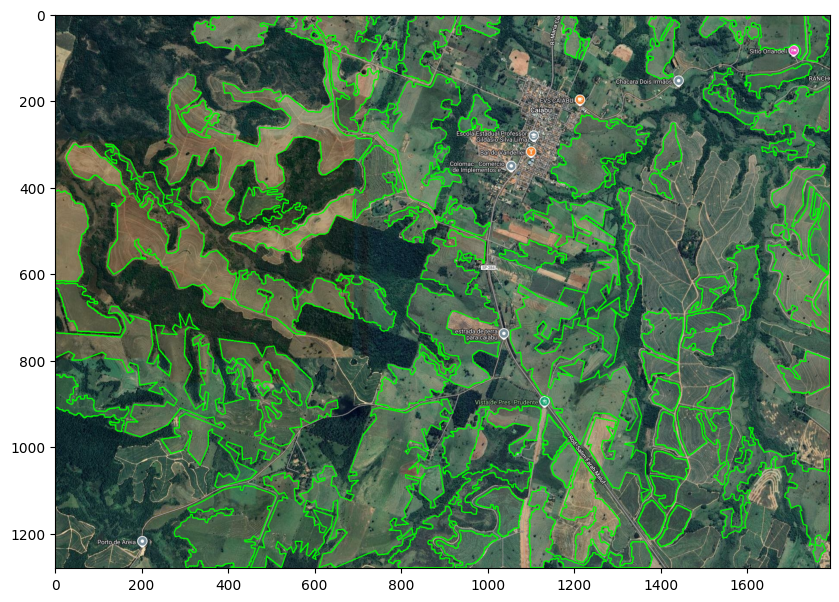

In [25]:
lat = -22.029617818808326
lon = -51.24574899673462
type = 1
result = FieldIdentifierService().identify_fields(lat, lon, type)

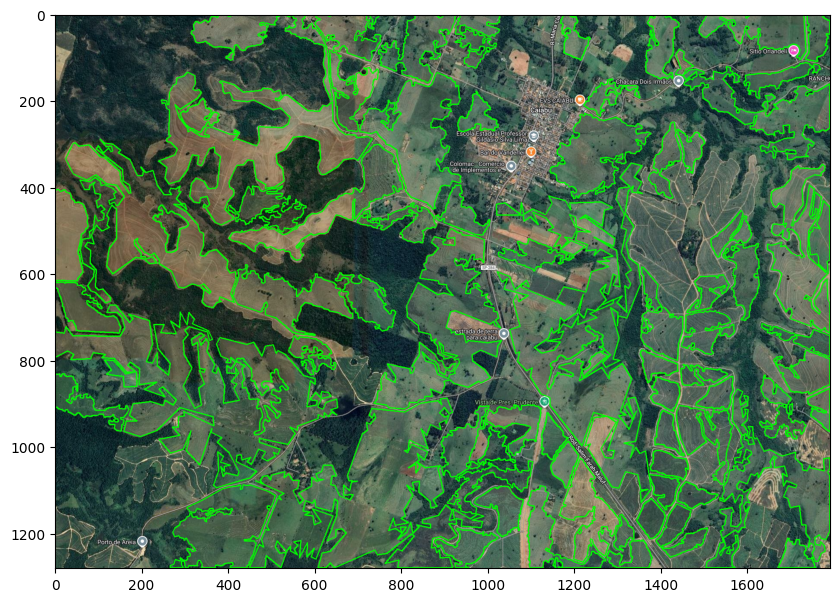

In [31]:
lat = -22.029617818808326
lon = -51.24574899673462
type = 1
result = FieldIdentifierService().identify_fields(lat, lon, type)

In [32]:
def baixar_imagem_google_maps(x, y, z):
    """
    Função para baixar uma imagem de um tile específico do Google Maps.
    """
    url = f"https://mts1.google.com/vt/lyrs=y&hl=en&src=app&x={x}&y={y}&z={z}&s=G"
    response = requests.get(url)
    
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content))
        # Converter a imagem para formato OpenCV (numpy array)
        image_cv = np.array(image)
        if image_cv.shape[2] == 4:
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGBA2BGR)
        else:
            image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2BGR)
        return image_cv
    else:
        raise Exception(f"Erro ao baixar imagem: {response.status_code}")

Baixando tiles de x: 11712 a 11718, y: 18583 a 18589
Total de tiles: 36
Área total trabalhada: 3.348 km²


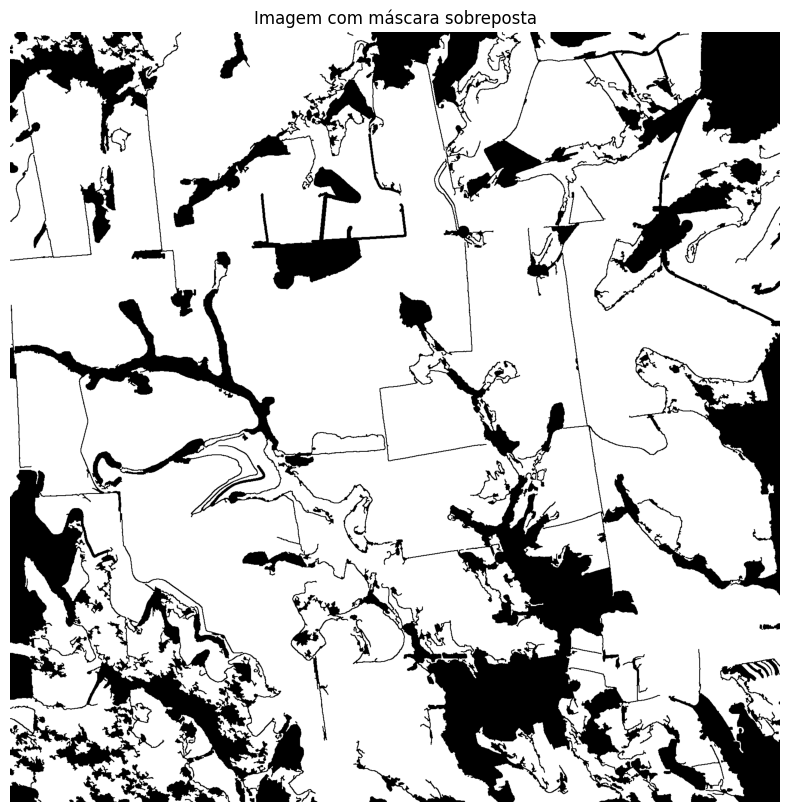

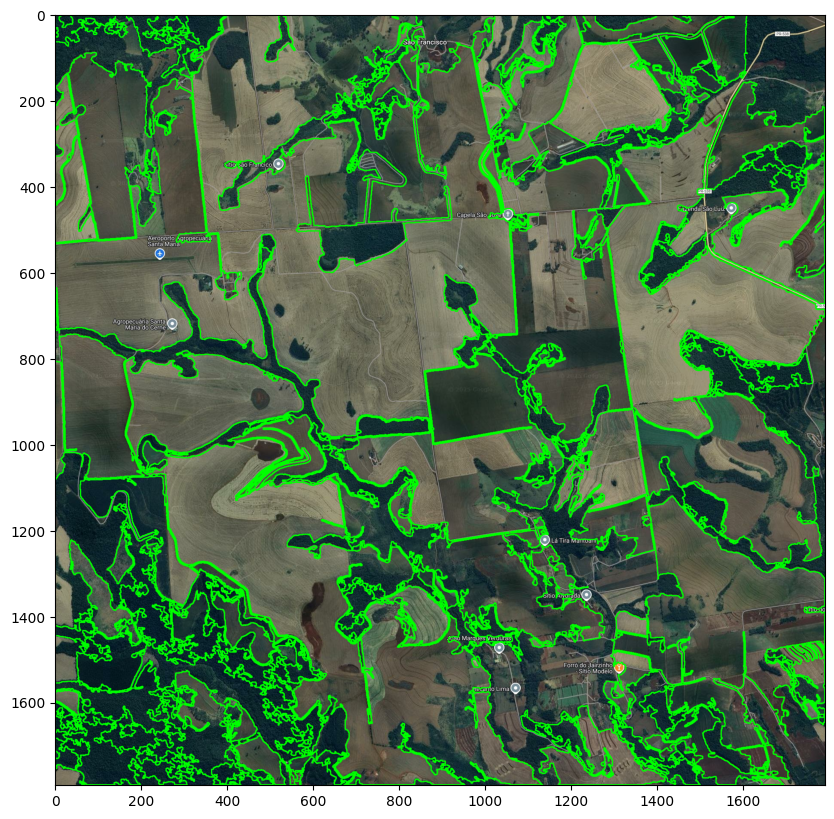

In [33]:
if __name__ == "__main__":
    # Defina a região de interesse (min_lat, min_lon, max_lat, max_lon)
    min_latitude = -23.5106705
    min_longitude = -51.2873264
    zoom = 15
    
    
    main(min_latitude, min_longitude, zoom)

Baixando tiles de x: 23463 a 23469, y: 37163 a 37173
Total de tiles: 60
Área total trabalhada: 5.58 km²


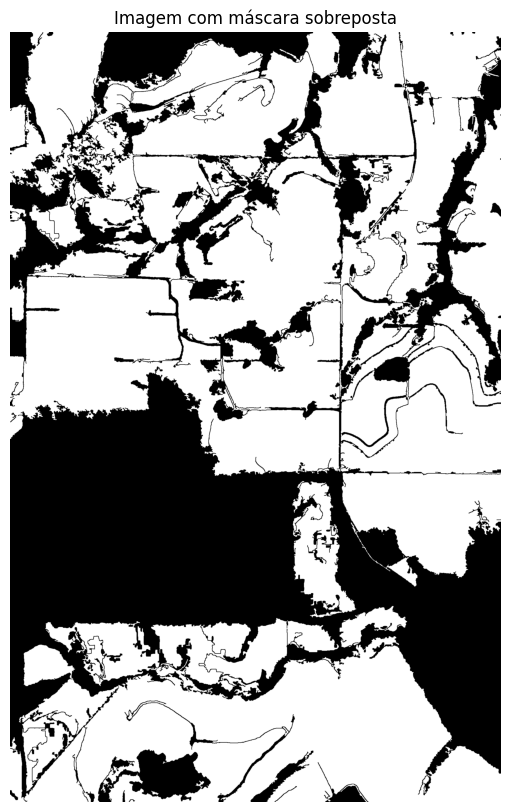

Skipping contour 1: not enough points to form a valid polygon.
Skipping contour 24: not enough points to form a valid polygon.
Polígonos salvos em 'poligonos.geojson'.
Tempo total de processamento: 15.55 segundos
Tempo por tile: 0.25924489498138426 segundos


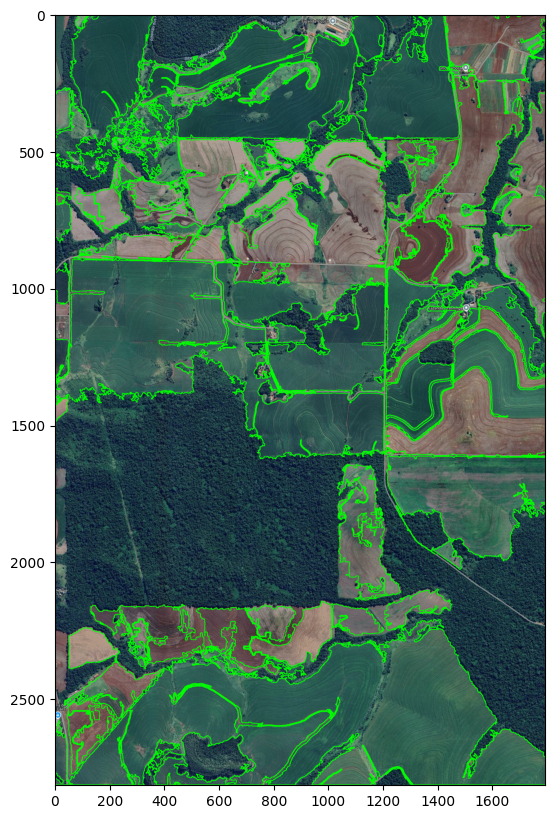

In [16]:
if __name__ == "__main__":
    # Defina a região de interesse (min_lat, min_lon, max_lat, max_lon)
    min_latitude = -23.46151
    min_longitude = -51.11267
    max_latitude = -23.5134
    max_longitude = -51.07786
    zoom = 16  # Ajuste o zoom conforme necessário
    main(min_latitude, min_longitude, max_latitude, max_longitude, zoom)


Baixando tiles de x: 23423 a 23431, y: 37065 a 37070
Total de tiles: 40
Área total trabalhada: 3.7199999999999998 km²


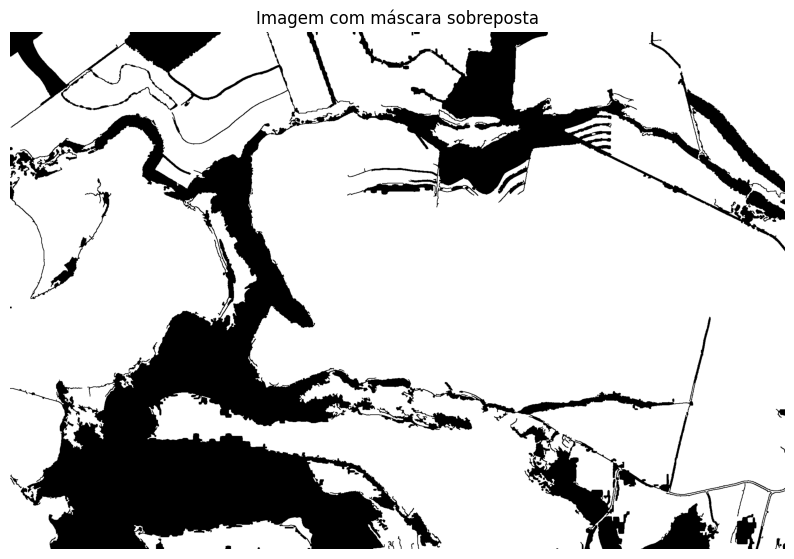

Polígonos salvos em 'poligonos.geojson'.
Tempo total de processamento: 10.76 segundos
Tempo por tile: 0.26909136176109316 segundos


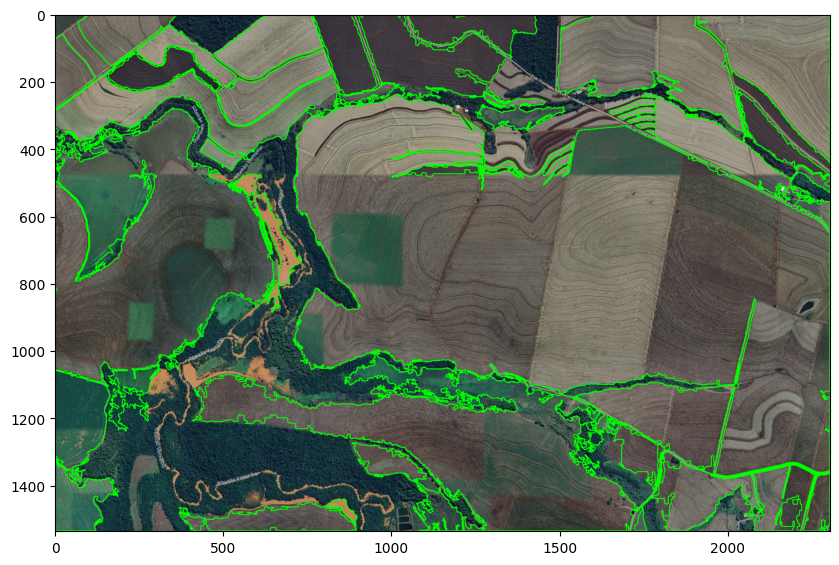

In [24]:
if __name__ == "__main__":
    # Defina a região de interesse (min_lat, min_lon, max_lat, max_lon)
    min_latitude = -22.99288
    min_longitude = -51.28436
    max_latitude = -22.96372
    max_longitude = -51.33127
    zoom = 16  # Ajuste o zoom conforme necessário
    main(min_latitude, min_longitude, max_latitude, max_longitude, zoom)
